In [2]:
import numpy as np
a = 3
N = 4

#0 3 5 6

# x 0 1 2 3 4 5 6 7 8
#
#   0 0 0 1 1 1 2 2 2
#   0 1 2 0 1 2 0 1 2
#                 |
#                 |


# x = np.random.randint(9)
x = 4
bin_x = "{0:b}".format(x)
bin_x = '0'*(N-len(bin_x)) + bin_x

print(x)
print(bin_x)

4
0100


In [3]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [4]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for j in range(size-1-i):
            for v1 in range(2):
                for v2 in range(2):
                    all_pat.append( [[1,1]]*i + bin_to_pattern(str(v1)) + [[1,1]]*j + bin_to_pattern(str(v2)) + [[1,1]]*(size-i-j-2))
    return all_pat

In [5]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [6]:
def overlapp(x,measurement):
    return np.prod( [np.dot(p1,p2) for p1,p2 in zip(x,measurement)] )

In [7]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [8]:
def decomposition(mat):
    a,b,c,d = mat[0],mat[1],mat[2],mat[3]
    return 1/4 * np.array( [a+b+c+d, a+b-c-d, a-b+c-d, a-b-c+d] )

In [9]:
pat = bin_to_pattern(bin_x)
# all_pat = all_config(4)
all_pat = create_specific_patterns(0,2,4) + create_specific_patterns(0,3,4) + create_specific_patterns(1,3,4) + create_specific_patterns(0,2,4) + create_specific_patterns(0,1,4)
print(len(all_pat))

y = np.matrix([ overlapp(pat,p) for p in all_pat]).T

A = np.matrix([ dev_pattern(p) for p in all_pat])

print( (A.T * y))

20
(20, 1)
[[3]
 [2]
 [1]
 [0]
 [5]
 [3]
 [3]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]]


In [42]:
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
# I, s1, s2, s3, s4, s1s2, s2s3, s3s4

#['IIII', 'IIZI', 'IIIZ', 'IIZZ', 'ZIII', 'ZIZI', 'ZIIZ', 'ZIZZ', 'IZII', 'IZZI', 'IZIZ', 'IZZZ', 'ZZII', 'ZZZI', 'ZZIZ', 'ZZZZ']

H_ops = []

for p,yi in zip(all_pat,y):

    ops = []
    for i in range(0,len(p),2):
        coefs = decomposition(dev_pattern([p[i],p[i+1]]))
        ops.append(SparsePauliOp(["II","ZI","IZ","ZZ"],coefs))
    op = ops[0]
    for i in range(1,len(ops)):
        op = op.tensor(ops[i])
    H_ops.append(op * yi[0,0])

#Recover paulis list
i=0
while len(H_ops[i].paulis)<=1:
    i+=1
paulis_idx = H_ops[i].paulis

#Recover coeffs of H
H = np.real(np.sum([ op.coeffs for op in H_ops ]))

for pstring,coef in zip(paulis_idx,H):
    print(pstring,coef)

# test = SparsePauliOp(paulis_idx,H)
# print(np.real(np.diag(test.to_matrix())))

IIII 1.25
IIZI 0.5
IIIZ 0.5
IIZZ 0.0
ZIII 1.0
ZIZI 0.5
ZIIZ 0.25
ZIZZ 0.0
IZII -0.5
IZZI 0.0
IZIZ -0.25
IZZZ 0.0
ZZII -0.25
ZZZI 0.0
ZZIZ 0.0
ZZZZ 0.0


In [43]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [44]:
def paulis_to_gates(pauli_string):
    idx = [i for i,s in enumerate(pauli_string) if s=='Z']
    # if len(idx)==2 and idx[1] == idx[0]+1:
    #     return []
    return idx

In [45]:
nqubits = N

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pstring,coef in zip(paulis_idx,H):
    if coef!=0:
        idx = paulis_to_gates(str(pstring))
        print(idx,coef)
        if len(idx)==1:
            qc_p.rz(2*gamma*coef,idx[0])
        if len(idx)==2:
            qc_p.rzz(2*gamma*coef,idx[0],idx[1])
    
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

[] 1.25
[2] 0.5
[3] 0.5
[0] 1.0
[0, 2] 0.5
[0, 3] 0.25
[1] -0.5
[1, 3] -0.25
[0, 1] -0.25


global phase: -1.5*$\gamma$
     ┌─────────┐┌────────────────┐ ┌──────────────────┐     »
q_0: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(2.0*$\gamma$) ├──■──»
     ├─────────┤├────────────────┤┌┴──────────────────┤  │  »
q_1: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(-1.0*$\gamma$) ├──┼──»
     ├─────────┤├────────────────┤└┬──────────────────┤┌─┴─┐»
q_2: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(1.0*$\gamma$) ├┤ X ├»
     ├─────────┤├────────────────┤ ├──────────────────┤└───┘»
q_3: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(1.0*$\gamma$) ├─────»
     └─────────┘└────────────────┘ └──────────────────┘     »
«                                                                 »
«q_0: ──────────────────────■────■────────────────────────■───────»
«                           │    │                        │       »
«q_1: ──────────────────────┼────┼────────────────────────┼────■──»
«     ┌──────────────────┐┌─┴─┐  │                        │    │  »
«q_2: ┤ Rz(1.0*$\gamma$) ├┤ X ├──┼────────────────────────┼────┼──»
«     └──────────────────┘└───┘┌─┴─┐┌──────────────────┐┌─┴─┐┌─┴─┐»
«q_3: ─────────────────────────┤ X ├┤ Rz(0.5*$\gamma$) ├┤ X ├┤ X ├»
«                              └───┘└──────────────────┘└───┘└───┘»
«                                                              
«q_0: ────────────────────────────■─────────────────────────■──
«                               ┌─┴─┐┌───────────────────┐┌─┴─┐
«q_1: ───────────────────────■──┤ X ├┤ Rz(-0.5*$\gamma$) ├┤ X ├
«                            │  └───┘└───────────────────┘└───┘
«q_2: ───────────────────────┼─────────────────────────────────
«     ┌───────────────────┐┌─┴─┐                               
«q_3: ┤ Rz(-0.5*$\gamma$) ├┤ X ├───────────────────────────────
«     └───────────────────┘└───┘

In [46]:
from bitstring import BitArray

def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(theta):

    nqubits = N
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                if len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [54]:
from scipy.optimize import minimize


expectation = get_expectation()

res = minimize(expectation, 
                      np.ones(300), 
                      method='COBYLA')
res

     fun: -2.8740234375
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([0.99925213, 2.01704446, 2.05146133, 1.01842274, 1.00886631,
       1.00022981, 1.00079908, 0.99864114, 1.00235985, 0.99842425,
       1.00107671, 1.02346502, 0.99759795, 0.99979975, 1.00029502,
       1.00338845, 1.00139049, 1.00123657, 0.99851644, 0.99946371,
       1.00162528, 1.00288124, 1.00029119, 0.96767289, 0.98092588,
       1.00921463, 1.00934247, 1.01506569, 0.99406835, 1.02443548,
       2.00091945, 0.97113097, 1.00179658, 1.00041257, 0.93591823,
       0.96097592, 1.00257045, 1.00476147, 1.00525614, 1.00570057,
       1.00442157, 1.00333681, 1.00109831, 1.00061836, 1.0022463 ,
       1.00245264, 1.00553358, 1.00360435, 1.00566342, 1.00365103,
       1.00445548, 1.00167715, 1.00530653, 1.00358495, 1.00215004,
       1.00468724, 1.00085554, 1.0033649 , 1.00580068, 1.00393606,
       1.00125805, 1.00395184, 1.00

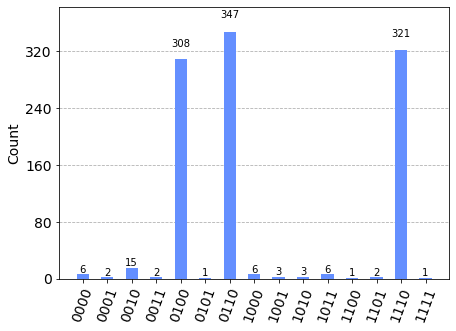

In [55]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)